In [1]:
import sys, importlib
sys.path.append('../')

from scipy.optimize import least_squares
from Modules.Utils.Imports import *
from Modules.Utils.PDESolver import *
from Modules.Models.BuildBINNs import BINN
from Modules.Utils.ModelWrapper import ModelWrapper

In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

Device set to cpu


In [3]:
#
# parameters from delay-reaction-diffusion binn
#

path = '../Data/'
file_name = 'cell_density_profiles.npy'

# initial cell densities
densities = ['dens_10000', 'dens_12000', 'dens_14000', 
             'dens_16000', 'dens_18000', 'dens_20000']

model_options = [0, 1, 3, 11, 12] 
model_names = ['Ds_Gl','Dp_Gl','Dmlp_Gl','Dmlp_Gmlp',
               'TlDs_TlGl','TlDp_TlGl','TlDmlp_TlGl','TlDmlp_TlGmlp',
               'TmlpDs_TmlpGl','TmlpDp_TmlpGl','TmlpDmlp_TmlpGl','TmlpDmlp_TmlpGmlp']
weight = '_IC1e1_rerun_best_eval'
gamma = 0.2

# variable scales
x_scale = 1/1000 # micrometer -> millimeter
t_scale = 1/24 # hours -> days
u_scale = 1/(x_scale**2) # cells/um^2 -> cells/mm^2

# load data
file = np.load(path + file_name, allow_pickle=True).item()

In [4]:
def scalar_diffusion(u, D):
    return D*np.ones_like(u)

def porous_diffusion(u, D, m):
    return np.abs(D)*(u.clip(1e-4,np.inf)/(1.7e3))**np.abs(m)

def modified_porous_diffusion(u, D0, D, m):
    return np.abs(D0) + np.abs(D)*(u.clip(1e-4,np.inf)/(1.7e3))**np.abs(m)

def logistic_growth(u, r):
    return r*(1 - u/(1.7e3))

def logistic_delay(t, beta0, beta1):
    return 1/(1 + np.exp(-(beta0 + beta1*t)))

def FKPP(theta):
    def diffusion(u, t):
        D = scalar_diffusion(u, theta[0])
        return D
    def growth(u, t):
        G = logistic_growth(u, theta[1])
        return G
    u_sim = PDE_sim(PDE_RHS, u0, x, t, diffusion, growth)
    return u_sim

def PFKPP(theta):
    def diffusion(u, t):
        D = porous_diffusion(u, theta[0], theta[1])
        return D
    def growth(u, t):
        G = logistic_growth(u, theta[2])
        return G
    u_sim = PDE_sim(PDE_RHS, u0, x, t, diffusion, growth)
    return u_sim

def DPFKPP(theta):
    def diffusion(u, t):
        D = modified_porous_diffusion(u, theta[0], theta[1], theta[2])
        T = logistic_delay(t, theta[4], theta[5])
        return D*T
    def growth(u, t):
        G = logistic_growth(u, theta[3])
        T = logistic_delay(t, theta[4], theta[5])
        return G*T
    u_sim = PDE_sim(PDE_RHS, u0, x, t, diffusion, growth)
    return u_sim

def DPFKPP2(theta):
    def diffusion(u, t):
        D = porous_diffusion(u, theta[0], theta[1])
        T = logistic_delay(t, theta[3], theta[4])
        return D*T
    def growth(u, t):
        G = logistic_growth(u, theta[2])
        T = logistic_delay(t, theta[3], theta[4])
        return G*T
    u_sim = PDE_sim(PDE_RHS, u0, x, t, diffusion, growth)
    return u_sim

In [5]:
#
# evaluate DMLP GMLP and TMLP
#

def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

dmin = 0.0
dmax = 0.096
gmin = -0.48
gmax = 2.4

model_option = 11

u_list = []
t_list = []
D_list = []
G_list = []
T_list = []

# loop over initial densities
for i, density in enumerate(densities):

    # load data
    x = file[density]['x'][1:,0].copy() * x_scale
    t = file[density]['t'][:,0].copy() * t_scale
    X = file[density]['X'][1:,:].copy() * x_scale
    T = file[density]['T'][1:,:].copy() * t_scale
    U = file[density]['U_mean'][1:,:].copy() * u_scale

    # create meshes
    u_mesh = np.linspace(0, 2000, 201)
    u_data = np.linspace(np.min(U), np.max(U), 201)
    t_mesh = np.linspace(0, 2, 201)

    # compile BINN
    binn = BINN(delay=True).to(device)

    # compile model
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name='../Weights/'+file_name[:-4]+'_'+density[-5:])
    model.save_name += '_' + binn.name + weight
    model.load(model.save_name + '_model', device=device)

    # evaluate parameters
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
    D_data = to_numpy(binn.diffusion(to_torch(u_data)[:, None]))
    G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None]))
    G_data = to_numpy(binn.growth(to_torch(u_data)[:, None]))
    T1 = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
    T2 = to_numpy(binn.delay2(to_torch(t_mesh)[:, None]))

    # rescale time delays and diffusion/growth
    D_mesh *= np.max(T1)
    D_data *= np.max(T1)
    G_mesh *= np.max(T2)
    G_data *= np.max(T2)
    T1 /= np.max(T1)
    T2 /= np.max(T2)

    u_list.append(u_data)
    t_list.append(t_mesh)
    D_list.append(D_data)
    G_list.append(G_data)
    T_list.append(T1)

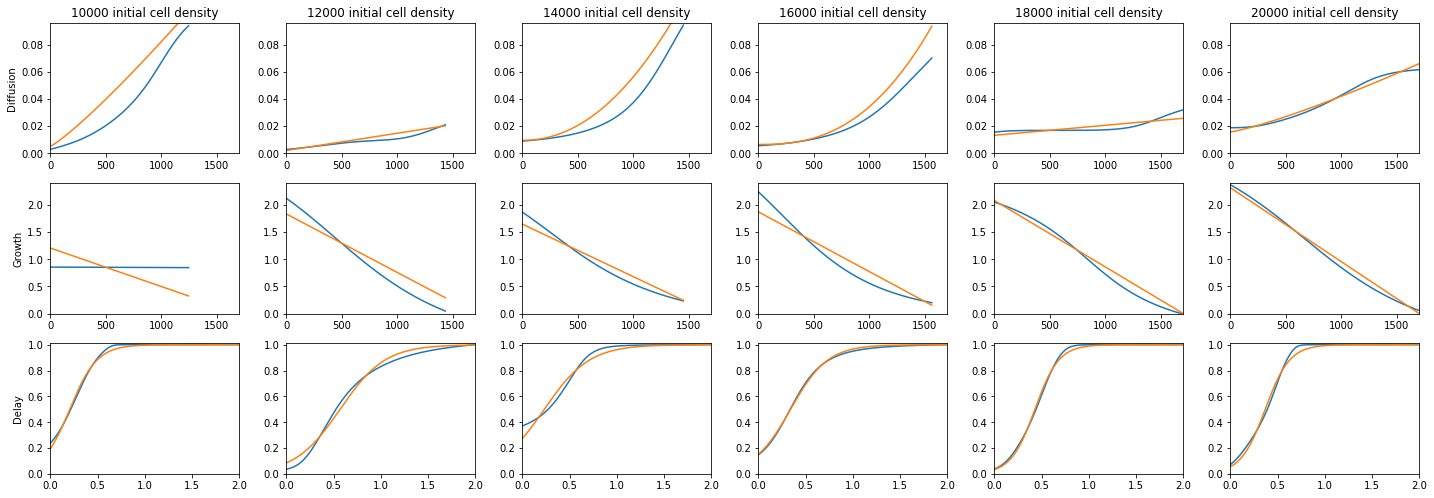

In [6]:
#
# initial conditions for D G and T
#

# classical fkpp
fkpp_D_init = [310, 250, 720, 570, 760, 1030]
fkpp_r_init = [0.044, 0.044, 0.048, 0.049, 0.054, 0.064]
fkpp_D_init = [D/u_scale/t_scale for D in fkpp_D_init]
fkpp_r_init = [r/t_scale for r in fkpp_r_init]

# porous fkpp
pfkpp_D_init = [1800, 1300, 3000, 2400, 2800, 2900]
pfkpp_m_init = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
pfkpp_r_init = [0.044, 0.043, 0.048, 0.049, 0.054, 0.064]
pfkpp_D_init = [D/u_scale/t_scale for D in pfkpp_D_init]
pfkpp_r_init = [r/t_scale for r in pfkpp_r_init]

# delay porous fkpp (need to be estimated from D_MLP G_MLP and T_MLP)
dpfkpp_D0_init    = []
dpfkpp_D_init     = []
dpfkpp_m_init     = []
dpfkpp_r_init     = []
dpfkpp_beta0_init = []
dpfkpp_beta1_init = []

# parameter bounds
dmin = 0.0
dmax = 0.096
gmin = 0.0 #-0.48
gmax = 2.4

fig = plt.figure(figsize=(20,7))
for idx in range(len(u_list)):

    t = t_list[idx]
    u = u_list[idx]
    D = D_list[idx]
    G = G_list[idx]
    T = T_list[idx]
    
    #
    # diffusion
    #
    
    def residual_fun(theta):
        pred = np.squeeze(modified_porous_diffusion(u, theta[0], theta[1], theta[2]))
        true = np.squeeze(D)
        return pred-true
    
    def mean_squared(theta):
        return np.mean(residual_fun(theta)**2)

    theta = scipy.optimize.minimize(mean_squared, [0.0, 0.0, 1.0], bounds=((dmin,dmax),(dmin,dmax),(0,4)))
    #theta = scipy.optimize.least_squares(residual_fun, 
    #                                     x0=[0.01, 0.09, 1.0], 
    #                                     method='trf', bounds=([dmin, dmin, 0], [dmax, dmax, 4]))
    
    ax = fig.add_subplot(3, 6, idx+1)
    plt.plot(u, D)
    plt.plot(u, modified_porous_diffusion(u_data,*theta.x))
    plt.xlim(0,1.7e3)
    plt.ylim(dmin,dmax)
    #plt.title(r'$D0={0:1.4f}, D={1:1.4f}, m={2:1.4f}$'.format(*theta.x))
    plt.title(str(densities[idx][-5:])+' initial cell density')
    if idx==0:
        plt.ylabel('Diffusion')
    
    dpfkpp_D0_init.append(theta.x[0])
    dpfkpp_D_init.append(theta.x[1])
    dpfkpp_m_init.append(theta.x[2])
    
    #
    # growth
    #
    
    def residual_fun(theta):
        pred = np.squeeze(logistic_growth(u, theta[0]))
        true = np.squeeze(G)
        return pred-true
    
    def mean_squared(theta):
        return np.mean(residual_fun(theta)**2)

    theta = scipy.optimize.minimize(mean_squared, [2.0], bounds=((gmin,gmax),))
    
    ax = fig.add_subplot(3, 6, idx+7)
    plt.plot(u, G)
    plt.plot(u, logistic_growth(u,*theta.x))
    plt.xlim(0,1.7e3)
    plt.ylim(gmin,gmax)
    #plt.title(r'$r={0:1.4f}$'.format(*theta.x))
    if idx==0:
        plt.ylabel('Growth')
    
    dpfkpp_r_init.append(theta.x[0])
    
    #
    # delay
    #
    
    def residual_fun(theta):
        pred = np.squeeze(logistic_delay(t, theta[0], theta[1]))
        true = np.squeeze(T)
        return pred-true
    
    def mean_squared(theta):
        return np.mean(residual_fun(theta)**2)

    theta = scipy.optimize.minimize(mean_squared, [1.0, 1.0])
    
    ax = fig.add_subplot(3, 6, idx+13)
    plt.plot(t, T)
    plt.plot(t, logistic_delay(t,*theta.x))
    plt.xlim(0,2)
    plt.ylim(0,1.01)
    #plt.title(r'$\beta_0={0:1.4f}, \beta_1={0:1.4f}$'.format(*theta.x))
    if idx==0:
        plt.ylabel('Delay')
    
    dpfkpp_beta0_init.append(theta.x[0])
    dpfkpp_beta1_init.append(theta.x[1])

plt.tight_layout(pad=1)
plt.show()

In [ ]:
#
# estimate model parameters
#

theta1 = [[],[],[],[]]

for model_option in [0, 1, 2]:

    for i, density in enumerate(densities):

        # grab x, t, and u from data
        x = file[density]['x'][1:,0].copy()
        t = file[density]['t'][:,0].copy()
        U = file[density]['U_mean'][1:,:].copy()

        # scale variables
        x *= x_scale
        t *= t_scale
        U *= u_scale

        # grab initial condition
        u0 = U[:,0].copy()

        # choose model
        if model_option == 0:
            model = FKPP 
            theta0 = [fkpp_D_init[i], fkpp_r_init[i]] 
            bounds = ((dmin,dmax),(gmin,gmax))
        if model_option == 1:
            model = PFKPP 
            theta0 = [pfkpp_D_init[i], pfkpp_m_init[i], pfkpp_r_init[i]]
            bounds = ((dmin,dmax),(0,4),(gmin,gmax))
        if model_option == 2:
            model = DPFKPP 
            theta0 = [dpfkpp_D0_init[i], dpfkpp_D_init[i], dpfkpp_m_init[i], 
                      dpfkpp_r_init[i], dpfkpp_beta0_init[i], dpfkpp_beta1_init[i]] 
            bounds = ((dmin,dmax),(dmin,dmax),(0,4),(gmin,gmax),(-10,10),(-10,10))
        if model_option == 3:
            model = DPFKPP2
            theta0 = [dpfkpp_D_init[i], dpfkpp_m_init[i], dpfkpp_r_init[i], 
                      dpfkpp_beta0_init[i], dpfkpp_beta1_init[i]] 
            bounds = ((dmin,dmax),(0,4),(gmin,gmax),(-10,10),(-10,10))

        def residual_fun(theta):
            u_pred = model(theta)
            u_true = U
            return (u_pred-u_true)*((np.abs(u_pred).clip(1,np.inf))**(-0.2))

        def mean_squared(theta):
            return np.mean(residual_fun(theta)**2)

        # least squares
        theta = scipy.optimize.minimize(mean_squared, theta0, bounds=bounds,)
        
        # store parameters
        theta1[model_option].append(theta.x)

        # simulate PDE
        u_sim = model(theta.x)

        # plot
        print(['FKPP','PFKPP','DPFKPP','DPFKPP2'][model_option])
        print(theta.x)
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        markers = ['x', 'o', 's', 'd', '^']
        fig = plt.figure(figsize=(15,8))  
        ax = fig.add_subplot(1, 1, 1)
        for i in range(len(X.T)):
            plt.plot(-1, -1, markers[i]+'-', c=colors[i])
        for i in range(len(X.T)):
            plt.plot(X[:,i], U[:,i], marker=markers[i], c=colors[i], linestyle='')
            plt.plot(x, u_sim[:,i], '-', c=colors[i])
        abs_error = np.mean((u_sim-U)**2)
        rel_error = np.mean(((u_sim-U)*np.abs(u_sim).clip(1.0,np.inf)**(-gamma))**2)
        plt.title('Initial cell density: '+density[5:7]+',000 cells per well')
        ax.set_xlabel('Position (mm)')
        ax.set_ylabel(r'Cell density (cells/mm$^2$)')
        plt.legend(['0.0 days', '0.5 days', '1.0 days', '1.5 days', '2.0 days'])
        plt.ylim(-100, 2200)
        plt.xlim(0, 2)
        plt.grid()
        plt.show()
        print()
    print()
    
#np.save('../Weights/mechanistic_model_parameters', theta1)

  FKPP


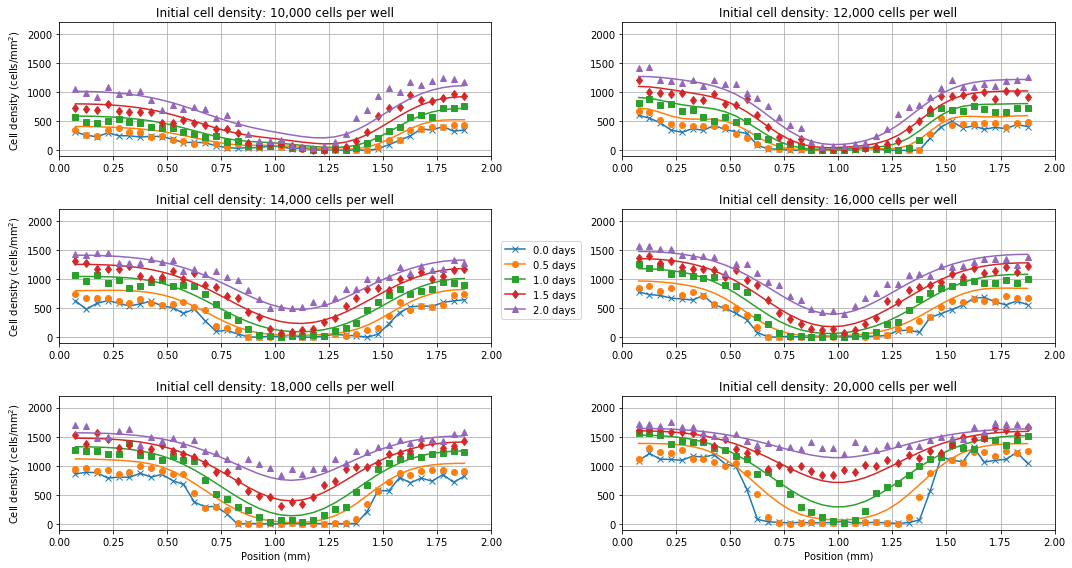


 PFKPP


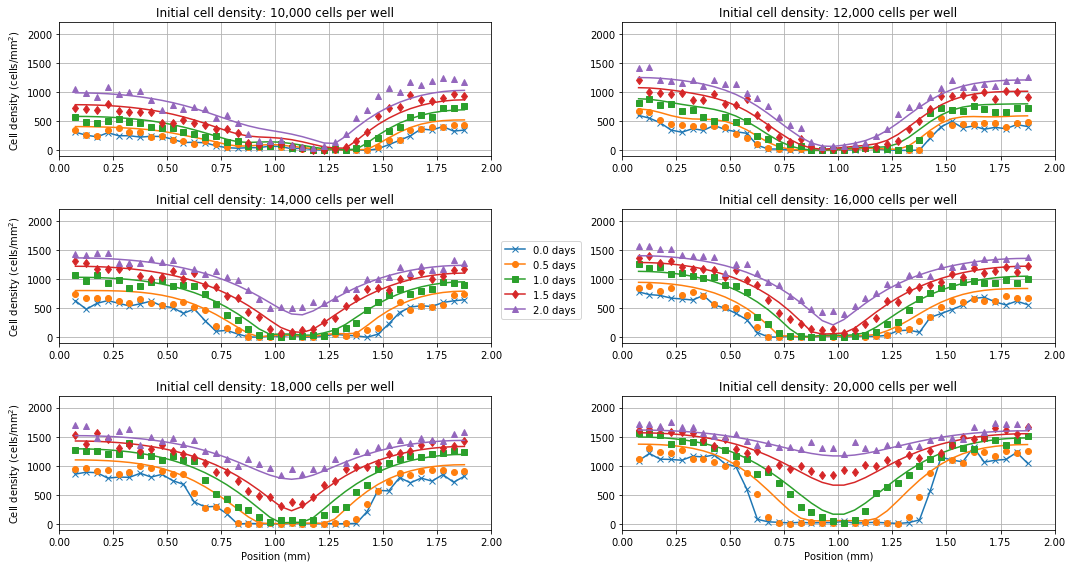


DPFKPP


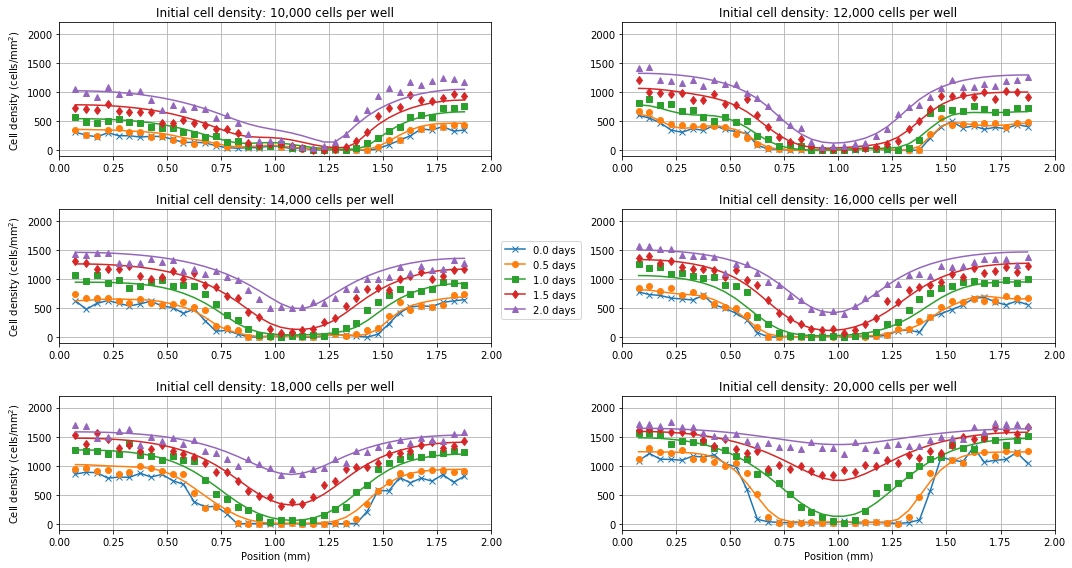

In [7]:
#
# AIC scores
#

theta1 = np.load('../Weights/mechanistic_model_parameters.npy',
                 allow_pickle=True)

def AIC_GLS(pred, true, kappa, N=37*5):
    residuals = pred - true
    residuals *= np.abs(pred).clip(1,np.inf)**(-0.2)
    return N*np.log(np.mean(residuals**2)) + 2*(kappa+1)

AICs = [[],[],[]]
RMSEs = [[],[],[]]
for model_option in [0, 1, 2]:
        
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    markers = ['x', 'o', 's', 'd', '^']
    fig = plt.figure(figsize=(15,8))  
    for j, density in enumerate(densities):

        # grab x, t, and u from data
        x = file[density]['x'][1:,0].copy()
        t = file[density]['t'][:,0].copy()
        X = file[density]['X'][1:,:].copy() * x_scale
        T = file[density]['T'][1:,:].copy() * t_scale
        U = file[density]['U_mean'][1:,:].copy()

        # scale variables
        x *= x_scale
        t *= t_scale
        U *= u_scale

        # grab initial condition
        u0 = U[:,0].copy()

        # choose model
        if model_option == 0:
            model = FKPP 
        if model_option == 1:
            model = PFKPP 
        if model_option == 2:
            model = DPFKPP 

        # parameters
        theta = theta1[model_option][j]

        # simulate PDE
        u_sim = model(theta)

        # compute AIC
        AICs[model_option].append(AIC_GLS(pred=u_sim, true=U, kappa=len(theta), N=37*5))
        
        # compute RMSE
        residuals = u_sim-U
        residuals *= np.abs(u_sim).clip(1.0,np.inf)**(-0.2)
        RMSEs[model_option].append(np.mean(residuals**2))

        # plot model solution
        ax = fig.add_subplot(3, 2, j+1)
        for i in range(len(X.T)):
            plt.plot(-1, -1, markers[i]+'-', c=colors[i])
        for i in range(len(X.T)):
            plt.plot(X[:,i], U[:,i], marker=markers[i], c=colors[i], linestyle='')
            plt.plot(x, u_sim[:,i], '-', c=colors[i])
        plt.title('Initial cell density: '+density[5:7]+',000 cells per well')
        if j in [4, 5]:
            ax.set_xlabel('Position (mm)')
        if j in [0, 2, 4]:
            ax.set_ylabel(r'Cell density (cells/mm$^2$)')
        if j+1 == 3:
            plt.legend(['0.0 days', '0.5 days', '1.0 days', '1.5 days', '2.0 days'], ncol=1, mode='expand',
                   bbox_to_anchor=(1.01, 0.2, 0.21, 0.6)) # (x, y, width, height)
        plt.ylim(-100, 2200)
        plt.xlim(0, 2)
        plt.grid()

    plt.tight_layout(h_pad=2, w_pad=2)
    plt.savefig('../Figures/mechanistic_'+['FKPP','PFKPP','DPFKPP'][model_option]+weight+'.pdf', format='pdf')
    print(['  FKPP',' PFKPP','DPFKPP'][model_option])
    plt.show()
    print()

In [8]:
print(' Model | 10,000 RMSE | 12,000 RMSE | 14,000 RMSE | 16,000 RMSE | 18,000 RMSE | 20,000 RMSE')
print('------------------------------------------------------------------------------------------')
for model_option in [0, 1, 2]:
    model = ['Classical FKPP','Porous-FKPP','BINN-guided model'][model_option]
    print(model+' & {0:5.2f} & {1:5.2f} & {2:5.2f} & {3:5.2f} & {4:5.2f} & {5:5.2f}'.format(*RMSEs[model_option]))
print()

print(' Model | 10,000 AIC | 12,000 AIC | 14,000 AIC | 16,000 AIC | 18,000 AIC | 20,000 AIC')
print('------------------------------------------------------------------------------------')
for model_option in [0, 1, 2]:
    model = ['Classical FKPP','Porous-FKPP','BINN-guided model'][model_option]
    print(model+' & {0:5.1f} & {1:5.1f} & {2:5.1f} & {3:5.1f} & {4:5.1f} & {5:5.1f}'.format(*AICs[model_option]))
print()

print(r' Model | 10,000 dAIC | 12,000 dAIC | 14,000 dAIC | 16,000 dAIC | 18,000 dAIC | 20,000 dAIC')
print('-------------------------------------------------------------------------------------------')
for model_option in [0, 1, 2]:
    model = ['Classical FKPP','Porous-FKPP','BINN-guided model'][model_option]
    dAICs = [AICs[model_option][i] - np.min([AICs[0][i],AICs[1][i],AICs[2][i]]) for i in range(6)]
    print(model+' & {0:5.2f} & {1:5.2f} & {2:5.2f} & {3:5.2f} & {4:5.2f} & {5:5.2f}'.format(*dAICs))

 Model | 10,000 RMSE | 12,000 RMSE | 14,000 RMSE | 16,000 RMSE | 18,000 RMSE | 20,000 RMSE
------------------------------------------------------------------------------------------
Classical FKPP & 786.80 & 557.28 & 616.76 & 619.12 & 685.17 & 964.19
Porous-FKPP & 681.18 & 540.29 & 418.57 & 566.89 & 744.44 & 928.38
BINN-guided model & 557.01 & 317.18 & 410.79 & 393.15 & 307.74 & 386.52

 Model | 10,000 AIC | 12,000 AIC | 14,000 AIC | 16,000 AIC | 18,000 AIC | 20,000 AIC
------------------------------------------------------------------------------------
Classical FKPP & 1239.6 & 1175.8 & 1194.5 & 1195.2 & 1214.0 & 1277.2
Porous-FKPP & 1214.9 & 1172.0 & 1124.8 & 1180.9 & 1231.3 & 1272.2
BINN-guided model & 1183.7 & 1079.5 & 1127.3 & 1119.2 & 1073.9 & 1116.1

 Model | 10,000 dAIC | 12,000 dAIC | 14,000 dAIC | 16,000 dAIC | 18,000 dAIC | 20,000 dAIC
-------------------------------------------------------------------------------------------
Classical FKPP & 55.90 & 96.26 & 69.71 & 76.01 & 

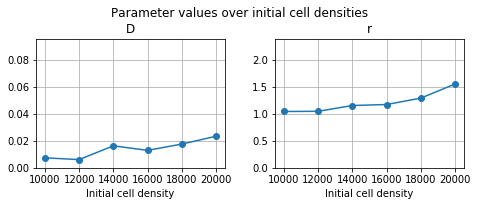

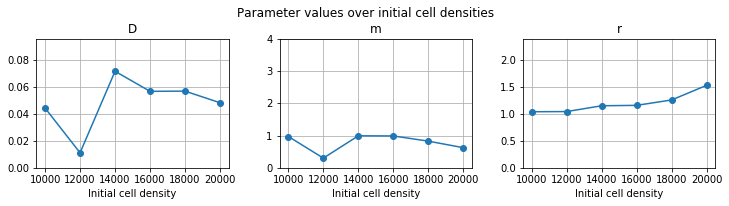

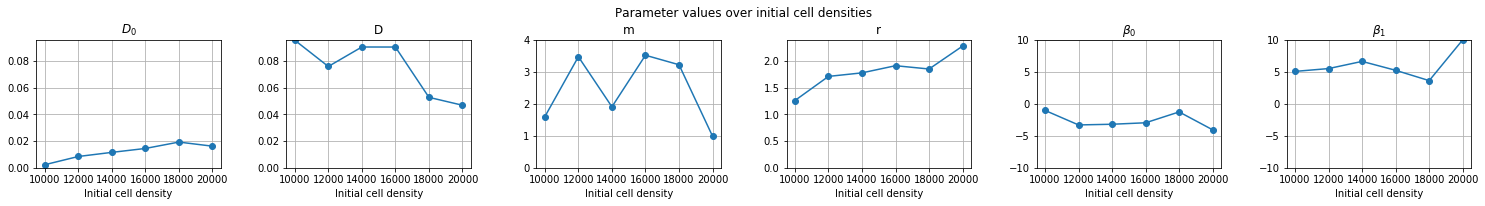

In [9]:
#
# parameter plots over density
#

# parameter bounds
dmin = 0.0
dmax = 0.096
gmin = 0.0 #-0.48
gmax = 2.4

# loop over models
for model_option in [0, 1, 2]:
    
    N = len(theta1[model_option][0])
    fig = plt.figure(figsize=(3.5*N, 3))
    
    if model_option == 0:
        names = ['D','r']
        bounds = ((dmin,dmax),(gmin,gmax))
    if model_option == 1:
        names = ['D','m','r']
        bounds = ((dmin,dmax),(0,4),(gmin,gmax))
    if model_option == 2:
        names = [r'$D_0$','D','m','r',r'$\beta_0$',r'$\beta_1$']
        bounds = ((dmin,dmax),(dmin,dmax),(0,4),(gmin,gmax),(-10,10),(-10,10))
    
    # loop over parameters
    for i in range(N):
        
        ax = fig.add_subplot(1, N, i+1)
        x = [1.0e4, 1.2e4, 1.4e4, 1.6e4, 1.8e4, 2.0e4]
        y = [theta1[model_option][j][i] for j in range(6)]
        plt.plot(x, y, '-o')
        plt.ylim(bounds[i])
        plt.xlabel('Initial cell density')
        plt.title(names[i])
        plt.grid()
        
    plt.suptitle('Parameter values over initial cell densities')
    plt.tight_layout(pad=2)
    plt.show()